# **Sentiment analysis using Neural networks with Twitter Data**

In [3]:
# Data manipulation and numerical computation
import numpy as np
import pandas as pd

# Text processing and visualization
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Deep Learning Frameworks
import tensorflow as tf
import keras
from tensorflow.keras import layers, models, losses, Sequential, optimizers, metrics

# Download necessary NLTK data files
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
print(keras.__version__)
print(tf.__version__)

3.8.0
2.18.0


# **Exploratory Data Analysis**

In [5]:
# === Data Loading and Overview ===
# Load the dataset
tweets_data = pd.read_csv('Tweets.csv')

# Display random samples to get a sense of the data
tweets_data.sample(10)

,textID,text,selected_text,sentiment
307,6943d0f480,_Live That`s what I want. More the better. Bou...,_Live That`s what I want. More the better. Bou...,neutral
19519,1ef5ffb626,Now only with Windows 7,Now only with Windows 7,neutral
7124,b05aa7feb8,wondering if anyone has seen my cell phone i c...,i cant find it,negative
10677,c94a85a39d,Delays/cancellations really bite. Have had ...,Delays/cancellations really bite. Have had my ...,neutral
2420,bf04914f83,so....i`m guessing no BGN?,so....i`m guessing no BGN?,neutral
13036,ff7f6efe91,Hey - Thank you!x and You`re Welcome! Must sa...,I love to travel,positive
13060,bae95611dd,Woo Hoo! It`s time to play 'Name That Twune',Woo Hoo! It`s time to play 'Name That Twune',neutral
8810,d7ee4047b7,wishing you were here too babe.. we`d have a ...,wishing,positive
14986,708e67409c,_BHB I went to that concert and I remember Der...,miss se,negative
2678,6631eb87ee,_Mcfly how cool will that be she is so nice!!...,how cool will that be she is so nice!!,positive


In [6]:
# Display column names
print(tweets_data.columns)

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')


In [7]:
# Get information about the dataset
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [8]:
# Check for missing values
print("Missing values per column:")
print(tweets_data.isnull().sum())

Missing values per column:
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [9]:
tweets_data = tweets_data.dropna()
tweets_data.isnull().sum()

,0
textID,0
text,0
selected_text,0
sentiment,0


In [10]:
tweets_data.duplicated().sum()

0

In [11]:
tweets_data = tweets_data.drop(columns=["selected_text", "textID"])

tweets_data.sample(10)

,text,sentiment
10558,my last full week of school!,neutral
26141,Loads of little jobs to do today. Going to be...,neutral
15681,Just woke up and catching up on the nightly tw...,neutral
9599,Yes we both do win!,positive
19809,"Back from the Gym, and sorting through my Inboxes",neutral
12373,"So happy. Great, glowy, ravey, beery night. No...",positive
21414,Viviann`s all minee. Yummm,positive
10122,http://twitpic.com/4nbx4 - great photo! bravi...,positive
2637,I hate it when I am in pain,negative
22781,HALLELUJAH! I`ve finally finished my Careers a...,positive


In [12]:
tweets_data["sentiment"].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


<Axes: xlabel='sentiment', ylabel='count'>

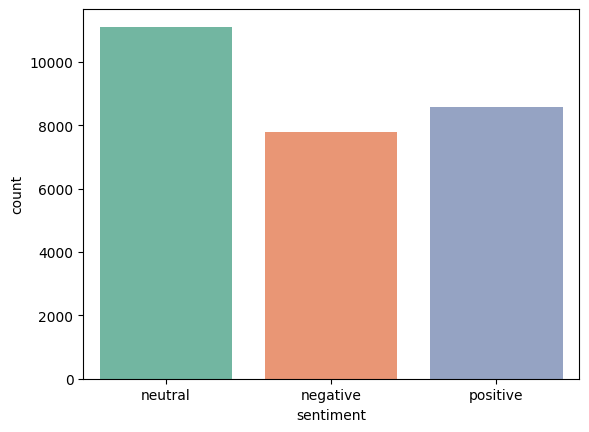

In [13]:
import seaborn as sns
sns.countplot(data=tweets_data, x="sentiment", palette="Set2", hue="sentiment")

In [14]:
tweets_data["word_count"] = tweets_data["text"].apply(lambda x: len(str(x).split(" ")))

tweets_data[["text", "word_count"]].sample(10)

,text,word_count
7514,"hahaha, yes, our discussions always seem to j...",11
8637,i hate interviews. im going to do horrible today,9
3452,oh.. tnx for following cass.,6
2824,*old me`s dead and gone*,5
194,I`m starving!! This diet is killing me but I c...,13
2200,Band work. I need my own laptop! buy me one I...,16
44,I love to! But I`m only available from 5pm. ...,22
16439,you`re welcome,3
5891,"yeah, that doesn`t sound very good",7
22277,finally -- someone recognizes my genius,7


In [15]:
# To check if the sentiment is dependent on word count
tweets_data.groupby("sentiment")["word_count"].mean()

,word_count
sentiment,
negative,14.244313
neutral,13.207610
positive,14.100210


In [16]:
# just to make sure that the mean in not much influenced by outliers
tweets_data.groupby("sentiment")["word_count"].median()

,word_count
sentiment,
negative,13.0
neutral,12.0
positive,13.0


<Axes: xlabel='word_count', ylabel='Count'>

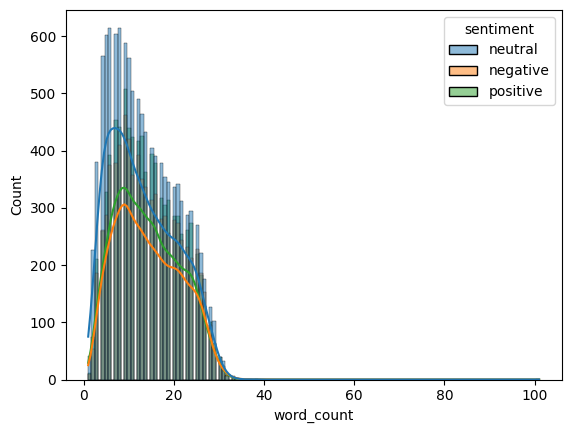

In [17]:
sns.histplot(data=tweets_data, x="word_count", hue="sentiment", kde=True)

<Axes: ylabel='word_count'>

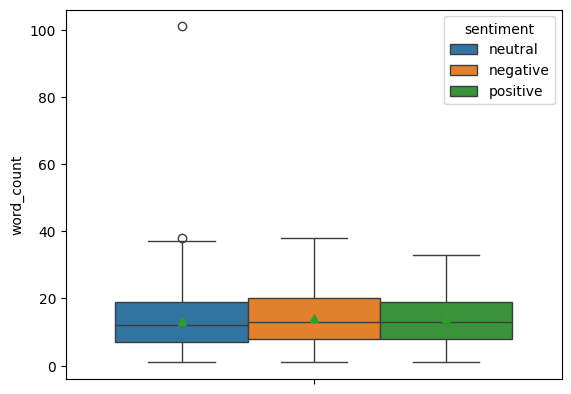

In [18]:
sns.boxplot(data=tweets_data, y="word_count", hue="sentiment", showmeans = True)

# **Cleaning and Preprocessing**

In [19]:
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = stopwords.words('english')

print(len(stop_words))
print(stop_words)

198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
import string

def custom_standardization(input_data):

  # convert to lowercase
  lowercase = tf.strings.lower(input_data)

  # Remove URLs
  stripped_urls = tf.strings.regex_replace(lowercase, r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '')

  # Remove email addresses
  stripped_emails = tf.strings.regex_replace(stripped_urls, r'\S*@\S*\s?', '')

  # Remove text in angular brackets(ususlly HTMl tags)
  stripped_brackets = tf.strings.regex_replace(stripped_emails, r'<.*?>+', '')

  # Removes any square brackets and leave text within the square brackets
  stripped_brackets = tf.strings.regex_replace(stripped_brackets, r'\[|\]', '')

  # Matche alphanumeric charecters with digits and remove those
  stripped_digits = tf.strings.regex_replace(stripped_brackets, r'\w*\d\w*', '')

  # Remove stopwords
  stripped_stopwords = tf.strings.regex_replace(stripped_digits, r"\b(?:{})\b".format("|".join(stop_words)), "")

  # Replace multiple whitespaces with a single whitespace
  stripped_whitespace = tf.strings.regex_replace(stripped_stopwords, r'\s+', ' ')

  # Removes non-alphabet characters
  stripped_non_alpha = tf.strings.regex_replace(stripped_whitespace, r'[^a-zA-Z\s]+', '')

  return stripped_non_alpha

In [21]:
tweets_data["text"][5]

'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth'

In [22]:
# using numpy because out custom function returns text in a tensor format
custom_standardization(tweets_data["text"][5]).numpy()

b'smf  shameless plugging best rangers forum earth'

In [23]:
print(tweets_data["text"][20])
print(tweets_data["text"][527])
print(tweets_data["text"][11827])

 oh Marly, I`m so sorry!!  I hope you find her soon!! <3 <3
i am living in ignorance  :@
My Degree  [Tear] happy moment!  http://mypict.me/1ZpF


In [24]:
print(custom_standardization(tweets_data["text"][20]).numpy())
print(custom_standardization(tweets_data["text"][527]).numpy())
print(custom_standardization(tweets_data["text"][11827]).numpy())

b' oh marly  sorry hope find soon  '
b' living ignorance '
b' degree tear happy moment '


In [25]:
tweets_data["cleaned_text"] = tweets_data["text"].apply(custom_standardization)

tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,8,"tf.Tensor(b' responded going', shape=(), dtyp..."
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,"tf.Tensor(b' sooo sad miss san diego', shape=(..."
2,my boss is bullying me...,negative,5,"tf.Tensor(b' boss bullying ', shape=(), dtype=..."
3,what interview! leave me alone,negative,6,"tf.Tensor(b' interview leave alone', shape=(),..."
4,"Sons of ****, why couldn`t they put them on t...",negative,15,tf.Tensor(b' sons put releases already bough...
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,18,tf.Tensor(b' wish could come see u denver husb...
27477,I`ve wondered about rake to. The client has ...,negative,26,tf.Tensor(b' wondered rake client made clear...
27478,Yay good for both of you. Enjoy the break - y...,positive,24,tf.Tensor(b' yay good enjoy break probably n...
27479,But it was worth it ****.,positive,8,"tf.Tensor(b' worth ', shape=(), dtype=string)"


In [26]:
# Define a function to convert tensor to string
def tensor_to_string(tensor):
    return tensor.numpy().decode('utf-8')

In [27]:
# Apply the fuction to DataFrame column
tweets_data["cleaned_text"] = tweets_data["cleaned_text"].apply(tensor_to_string)

tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,8,responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,sooo sad miss san diego
2,my boss is bullying me...,negative,5,boss bullying
3,what interview! leave me alone,negative,6,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,15,sons put releases already bought
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,18,wish could come see u denver husband lost job...
27477,I`ve wondered about rake to. The client has ...,negative,26,wondered rake client made clear net force...
27478,Yay good for both of you. Enjoy the break - y...,positive,24,yay good enjoy break probably need hectic w...
27479,But it was worth it ****.,positive,8,worth


# **Word clouds**

In [28]:
# Extract the text from poditive sentiemnt tweets
positive_tweets = tweets_data[tweets_data["sentiment"] == "positive"]["cleaned_text"]

# Concatenate all poitive sentiment tweets into a single string
positive_text = " ".join(positive_tweets)

# Create a wordCloud object
positive_wordcloud = WordCloud(width=800, height=800, background_color="white").generate(positive_text)

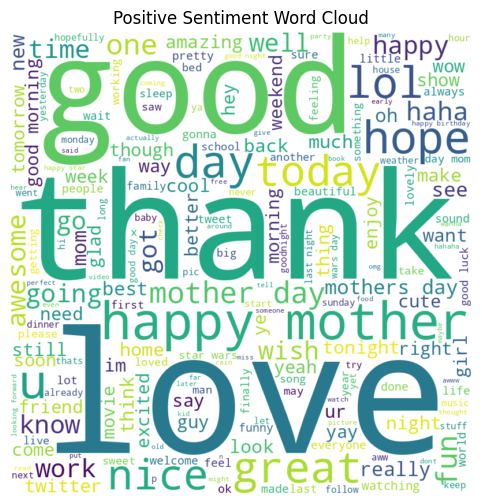

In [29]:
# Plot the wordcloud
plt.figure(figsize=(10, 6), facecolor=None)
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Sentiment Word Cloud")
plt.show()


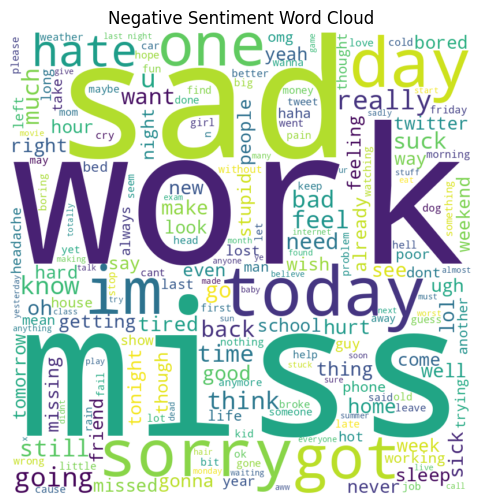

In [30]:

# Extract the text from negative sentiment tweets
negative_tweets = tweets_data[tweets_data["sentiment"] == "negative"]["cleaned_text"]

# Concatenate all negative sentiment tweets into a single string
negative_text = " ".join(negative_tweets)

# Create a wordCloud object
negative_wordcloud = WordCloud(width=800, height=800, background_color="white").generate(negative_text)

# Plot the wordcloud
plt.figure(figsize=(10, 6), facecolor=None)
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Sentiment Word Cloud")
plt.show()


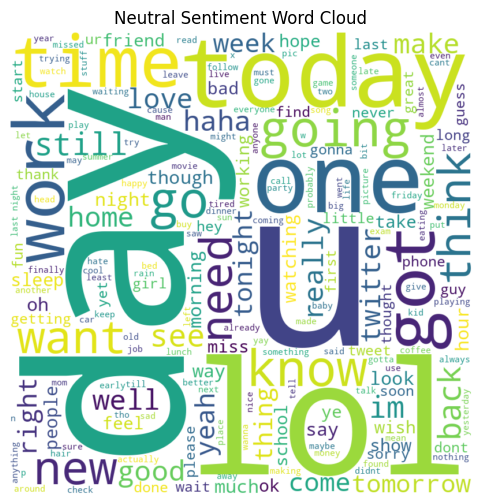

In [31]:
# Extract the text from neutral sentiment tweets
neutral_tweets = tweets_data[tweets_data["sentiment"] == "neutral"]["cleaned_text"]

# Concatenate all neutral sentiment tweets into a single string
neutral_text = " ".join(neutral_tweets)

# Create a wordCloud object
neutral_wordcloud = WordCloud(width=800, height=800, background_color="white").generate(neutral_text)

# Plot the wordcloud
plt.figure(figsize=(10, 6), facecolor=None)
plt.imshow(neutral_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Neutral Sentiment Word Cloud")
plt.show()


# **Feed forward neural network phase**

In [32]:
# Converting sentiment into numeric representation
tweets_data["sentiment"] = tweets_data["sentiment"].map({"positive": 2, "neutral": 1, "negative": 0})

tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",1,8,responded going
1,Sooo SAD I will miss you here in San Diego!!!,0,11,sooo sad miss san diego
2,my boss is bullying me...,0,5,boss bullying
3,what interview! leave me alone,0,6,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",0,15,sons put releases already bought
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,0,18,wish could come see u denver husband lost job...
27477,I`ve wondered about rake to. The client has ...,0,26,wondered rake client made clear net force...
27478,Yay good for both of you. Enjoy the break - y...,2,24,yay good enjoy break probably need hectic w...
27479,But it was worth it ****.,2,8,worth


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(tweets_data, test_size=0.2, stratify=tweets_data['sentiment'], random_state=123)
X_train, X_val = train_test_split(X_train, test_size=0.1, stratify=X_train['sentiment'], random_state=123)

X_train.shape, X_val.shape, X_test.shape

# X_train = To train
# X_val = To validate during training
# X_test = To evaluate model

((19785, 4), (2199, 4), (5496, 4))

In [34]:
print(X_train['sentiment'].value_counts())
print(X_val['sentiment'].value_counts())
print(X_test['sentiment'].value_counts())

sentiment
1    8005
2    6178
0    5602
Name: count, dtype: int64
sentiment
1    889
2    687
0    623
Name: count, dtype: int64
sentiment
1    2223
2    1717
0    1556
Name: count, dtype: int64


In [35]:
raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train['text'].values, X_train['sentiment'].values)).shuffle(1024).batch(batch_size=128)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val['text'].values, X_val['sentiment'].values)).batch(batch_size=128)

raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test['text'].values, X_test['sentiment'].values)).batch(batch_size=128)

len(raw_train_ds), len(raw_val_ds), len(raw_test_ds)


(155, 18, 43)

In [36]:
# Display a single batch from raw_test_ds
for text, sentiment in raw_test_ds.take(1):
    print("Text:", text.numpy()[:3])  # Display first 3 samples
    print("Sentiment:", sentiment.numpy()[:3])  # Display corresponding labels


Text: [b'Loving my boys' b' have a good show' b' nope  het is LOST&found he ;-)']
Sentiment: [2 2 0]


In [37]:
# Check the structure of the dataset
print(raw_test_ds.element_spec)

(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


# **Count vectorization**

In [38]:
vocab_size = 10000

count_vectorizer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='count',
    ngrams=(1,2)
)

In [39]:
train_text = raw_train_ds.map(lambda x, y:x)

count_vectorizer.adapt(train_text)

In [40]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)

  return count_vectorizer(text), label

In [41]:
import sys
np.set_printoptions(threshold=sys.maxsize)

class_names = ["positive", "neutral", "negative"]
text_batch, label_batch = next(iter(raw_train_ds))
first_tweet, first_label = text_batch[0], label_batch[0]

print("Tweet: ", first_tweet)
print("Sentiment: ", class_names[first_label])
print("Vectorized tweet: ", vectorize_text(first_tweet, first_label))

Tweet:  tf.Tensor(b' whaatttaatttt! she is a good cook and really creative, silly sierra', shape=(), dtype=string)
Sentiment:  negative
Vectorized tweet:  (<tf.Tensor: shape=(1, 10000), dtype=int64, numpy=
array([[8, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [42]:
vocab_size = count_vectorizer.get_vocabulary()
len(vocab_size)

10000

In [43]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
dnn_model = Sequential([
    layers.Dense(64, activation='tanh'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='tanh'),
    layers.Dropout(0.1),
    layers.Dense(3)
])

In [46]:
dnn_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

input_shape = (None, 10000)

dnn_model.build(input_shape)

dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 642,243 (2.45 MB)

 Trainable params: 642,243 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = dnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.3905 - loss: 1.0934 - val_accuracy: 0.4948 - val_loss: 1.0403
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5317 - loss: 1.0190 - val_accuracy: 0.5725 - val_loss: 0.9759
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6214 - loss: 0.9344 - val_accuracy: 0.6207 - val_loss: 0.9049
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6771 - loss: 0.8388 - val_accuracy: 0.6558 - val_loss: 0.8443
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7209 - loss: 0.7515 - val_accuracy: 0.6730 - val_loss: 0.8026
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7462 - loss: 0.6793 - val_accuracy: 0.6821 - val_loss: 0.7785
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7714 - loss: 0.6197 - val_accuracy: 0.6944 - val_loss: 0.7677
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7909 - loss: 0.5723 - val_accuracy: 0

In [48]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6777 - loss: 0.7823
Loss:  0.7978662252426147
Accuracy:  0.6757642030715942


In [49]:
history_dict = history.history

history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [50]:
history_df = pd.DataFrame(history_dict)

history_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.438969,1.074534,0.494770,1.040289
1,0.547738,1.003362,0.572533,0.975931
2,0.631034,0.916048,0.620737,0.904862
3,0.682942,0.822052,0.655753,0.844265
4,0.723427,0.738035,0.673033,0.802557


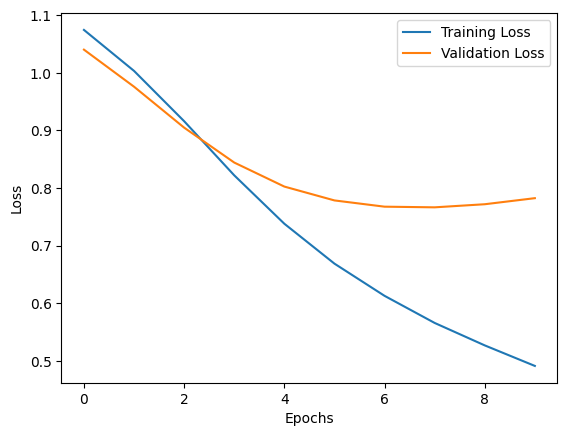

In [51]:
# Plot against training and validation loss
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

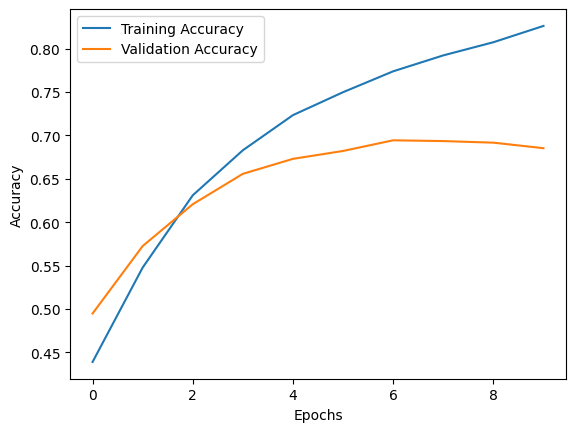

In [52]:
# Plot against training and validation accuracy
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
export_model = Sequential([
    count_vectorizer,
    dnn_model
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6777 - loss: 0.7823
Loss:  0.7978662252426147
Accuracy:  0.6757642030715942


In [54]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

predictions = export_model.predict(X_test["text"].values)

y_pred = np.argmax(predictions, axis=1)
y_test = X_test["sentiment"]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average=None)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

report = classification_report(y_test, y_pred)

print( report)



172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.68      0.61      0.64      1556
           1       0.63      0.70      0.66      2223
           2       0.74      0.71      0.72      1717

    accuracy                           0.68      5496
   macro avg       0.68      0.67      0.68      5496
weighted avg       0.68      0.68      0.68      5496



# **Using TF-IDF as vectorizer**

In [55]:
vocab_size = 10000
tfidf_vectorizer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='tf_idf',
    ngrams=(1,2)
)

tfidf_vectorizer.adapt(train_text)

In [56]:
def vectorize_text_tf_idf(text, label):
  text = tf.expand_dims(text, -1)

  return tfidf_vectorizer(text), label

In [57]:
train_ds = raw_train_ds.map(vectorize_text_tf_idf)
val_ds = raw_val_ds.map(vectorize_text_tf_idf)
test_ds = raw_test_ds.map(vectorize_text_tf_idf)

In [58]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [59]:
dnn_model = Sequential([
    layers.Dense(64, activation='tanh'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='tanh'),
    layers.Dropout(0.1),
    layers.Dense(3)
])

In [60]:
dnn_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

input_shape = (None, 10000)

dnn_model.build(input_shape)

dnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 642,243 (2.45 MB)

 Trainable params: 642,243 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
history = dnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40
)

Epoch 1/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.3716 - loss: 1.1298 - val_accuracy: 0.4156 - val_loss: 1.0863
Epoch 2/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3914 - loss: 1.1015 - val_accuracy: 0.4411 - val_loss: 1.0694
Epoch 3/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4127 - loss: 1.0837 - val_accuracy: 0.4593 - val_loss: 1.0540
Epoch 4/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4386 - loss: 1.0652 - val_accuracy: 0.4866 - val_loss: 1.0395
Epoch 5/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4659 - loss: 1.0430 - val_accuracy: 0.5107 - val_loss: 1.0254
Epoch 6/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4828 - loss: 1.0253 - val_accuracy: 0.5198 - val_loss: 1.0116
Epoch 7/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5109 - loss: 1.0088 - val_accuracy: 0.5339 - val_loss: 0.9980
Epoch 8/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5300 - loss: 0.9866 - val_accuracy: 0

In [62]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6741 - loss: 0.7801
Loss:  0.7944201827049255
Accuracy:  0.6661208271980286


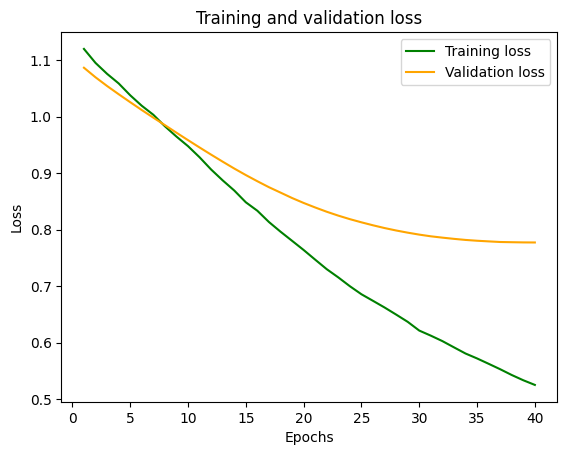

In [63]:
#plot  against training and validation loss

history_dict = history.history

history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color= "green", label='Training loss')
plt.plot(epochs, val_loss, color="orange", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0, 0.5, 'Accuracy')

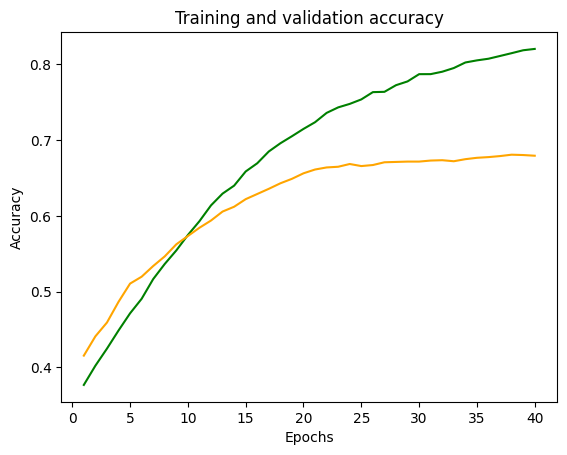

In [64]:
plt.plot(epochs, acc, color= "green", label='Training acc')
plt.plot(epochs, val_acc, color="orange", label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# **Text to Embeddings**

In [65]:
vocab_size = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [66]:
train_text=raw_train_ds.map(lambda x, y:x)

vectorize_layer.adapt(train_text)

In [67]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)

  return vectorize_layer(text), label

In [68]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [69]:
test_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [70]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

We are using a callback list here

Early stopping — Interrupting training when the validation loss is no longer improving (and save the best model obtained during training). ReduceLROnPlateau-Dynamically adjusting the value of certain parameters during training such as the learning rate optimizer. Tensorboard-Logging training and validation metrics during training or visualizing representations learned by the model as they’re updated. (The Keras progress bar we always see in our terminal during training!)

Callbacks are passed to the during via the callback argument in the fit() method which takes a list of callbacks. Any number of callbacks can be passed to it.

The monitor argument in the EarlyStopping callback monitor’s the model’s validation accuracy and the patience argument interrupts training when the parameter passed to the monitor argument stops improving for more than the number (of epochs) passed to it (in this case 3).

Also, the ReduceLROnPlateau callback is used to reduce the learning rate when the validation loss has stopped improving. This has proven to be a very effective strategy to get out of local minima during training. The factor argument takes as input a float which is used to multipy the learning rate when triggered.Factor by which the learning rate will be reduced. new_lr = lr * factor.

In [71]:
callback_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3
    ),
    keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        patience=1
    )
]

**Neural network creation is started**

In [72]:
embedding_dim = 64

model = Sequential([
    layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='tanh'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='tanh'),
    layers.Dropout(0.1),
    layers.Dense(3)
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [73]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callback_list
  )

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.3931 - loss: 1.0921 - val_accuracy: 0.4043 - val_loss: 1.0933 - learning_rate: 0.0010
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4032 - loss: 1.0886 - val_accuracy: 0.4043 - val_loss: 1.0927 - learning_rate: 0.0010
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4049 - loss: 1.0874 - val_accuracy: 0.4043 - val_loss: 1.0914 - learning_rate: 0.0010
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4088 - loss: 1.0836 - val_accuracy: 0.4143 - val_loss: 1.0653 - learning_rate: 0.0010
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4171 - loss: 1.0688 - val_accuracy: 0.4120 - val_loss: 1.0596 - learning_rate: 0.0010
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4611 - loss: 1.0403 - val_accuracy: 0.5312 - val_loss: 0.9907 - learning_rate: 0.0010
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4999 - loss: 0.9798 -

In [74]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ",loss)
print("Accuracy: ",accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6676 - loss: 0.7955
Loss:  0.8063151240348816
Accuracy:  0.6681222915649414


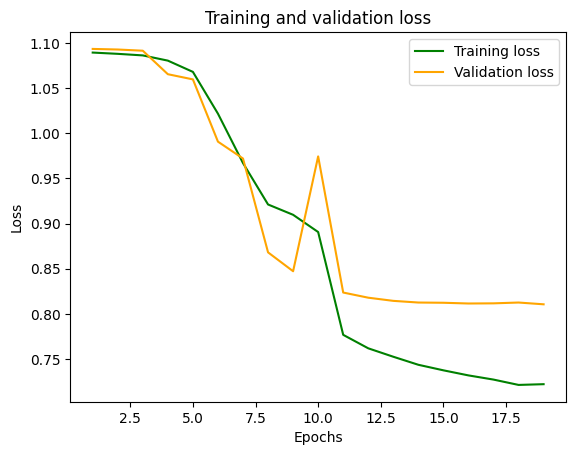

In [75]:
#plot  against training and validation loss

history_dict = history.history

history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color= "green", label='Training loss')
plt.plot(epochs, val_loss, color="orange", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0, 0.5, 'Accuracy')

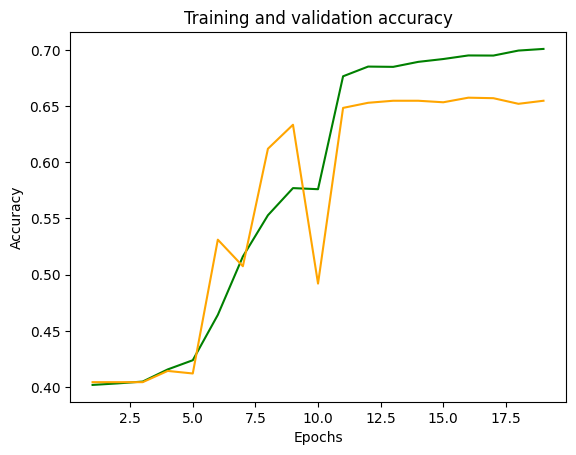

In [76]:
plt.plot(epochs, acc, color= "green", label='Training acc')
plt.plot(epochs, val_acc, color="orange", label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# **Recurrent Neural network**

In [77]:
embedding_dim = 128

rnn_model = Sequential()

rnn_model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))
rnn_model.add(layers.SimpleRNN(128, return_sequences=True))
rnn_model.add(layers.GlobalMaxPool1D())
rnn_model.add(layers.Dense(3,activation='softmax'))

rnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = rnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callback_list
)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4570 - loss: 1.0304 - val_accuracy: 0.6753 - val_loss: 0.7759 - learning_rate: 0.0010
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7097 - loss: 0.6983 - val_accuracy: 0.6926 - val_loss: 0.7380 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8015 - loss: 0.5332 - val_accuracy: 0.6839 - val_loss: 0.7860 - learning_rate: 0.0010
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8655 - loss: 0.4031 - val_accuracy: 0.6903 - val_loss: 0.8255 - learning_rate: 1.0000e-04
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8770 - loss: 0.3665 - val_accuracy: 0.6871 - val_loss: 0.8288 - learning_rate: 1.0000e-05


In [78]:
loss, accuracy = rnn_model.evaluate(test_ds)

print("Loss: ",loss)
print("Accuracy: ",accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6827 - loss: 0.8231
Loss:  0.8324658870697021
Accuracy:  0.681768536567688


# **Training LSTM Network**

In [79]:
embedding_dim = 128

lstm_model = Sequential()

lstm_model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))
lstm_model.add(layers.SpatialDropout1D(0.25))
lstm_model.add(layers.LSTM(128, dropout= 0.6, return_sequences=True))
lstm_model.add(layers.GlobalMaxPooling1D())
lstm_model.add(layers.Dense(32,activation='tanh'))
lstm_model.add(layers.Dense(3,activation='softmax'))

lstm_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = lstm_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callback_list
)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4554 - loss: 1.0361 - val_accuracy: 0.6658 - val_loss: 0.7803 - learning_rate: 0.0010
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6925 - loss: 0.7327 - val_accuracy: 0.7099 - val_loss: 0.7340 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7451 - loss: 0.6358 - val_accuracy: 0.7012 - val_loss: 0.7552 - learning_rate: 0.0010
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7880 - loss: 0.5521 - val_accuracy: 0.7012 - val_loss: 0.7658 - learning_rate: 1.0000e-04
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7936 - loss: 0.5379 - val_accuracy: 0.7117 - val_loss: 0.7512 - learning_rate: 1.0000e-05
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7970 - loss: 0.5344 - val_accuracy: 0.7076 - val_loss: 0.7542 - learning_rate: 1.0000e-06
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.793

In [80]:
loss, accuracy = lstm_model.evaluate(test_ds)

print("Loss: ",loss)
print("Accuracy: ",accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6892 - loss: 0.7652
Loss:  0.7621630430221558
Accuracy:  0.6945050954818726


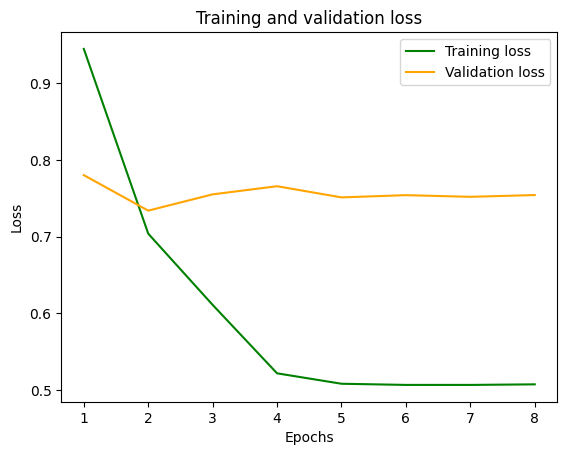

In [81]:
#plot  against training and validation loss

history_dict = history.history

history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color= "green", label='Training loss')
plt.plot(epochs, val_loss, color="orange", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0, 0.5, 'Accuracy')

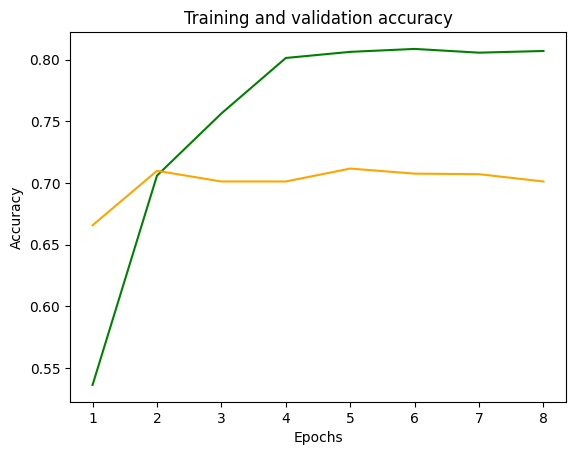

In [82]:
plt.plot(epochs, acc, color= "green", label='Training acc')
plt.plot(epochs, val_acc, color="orange", label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


In [83]:
export_model = Sequential([
    vectorize_layer,
    lstm_model
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6966 - loss: 0.7608
Loss:  0.7612037062644958
Accuracy:  0.6970524191856384


In [86]:
def predict_sentiment(text):
    text = tf.constant([text])

    prediction = export_model.predict(text)
    predicted_class = np.argmax(prediction, axis=1)[0]

    sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
    sentiment = sentiment_labels.get(predicted_class, "Unknown")

    print(f"Input Text: {text.numpy()[0]}")
    print(f"Predicted Sentiment: {sentiment}")

In [87]:
user_input = input("Enter a tweet or text to analyze sentiment: ")
predict_sentiment(user_input)

Enter a tweet or text to analyze sentiment: this AI related article is very good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Input Text: b'this AI related article is very good'
Predicted Sentiment: Positive


In [88]:
user_input = input("Enter a tweet or text to analyze sentiment: ")
predict_sentiment(user_input)

Enter a tweet or text to analyze sentiment: this experience has been the worst, want my money back
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Input Text: b'this experience has been the worst, want my money back'
Predicted Sentiment: Negative
